In [35]:
import numpy as np
import matplotlib.pyplot as plt

from pixelfly import PixelflyBoard, Mode, BinMode, PixelDepth
from analyze_spots import GridSpotAnalyzer
from homogenize.homogenize import homogenize
from trap_signal_generator.configuration import StaticTrapConfiguration
from trap_signal_generator.runtime import StaticTrapGenerator

In [45]:
pixelfly = PixelflyBoard(
    name="pixelfly",
    board_number=0,
    mode=Mode.SW_TRIGGER | Mode.ASYNC_SHUTTER,
    exp_time=30,
    hbin=BinMode.BIN_1X,
    vbin=BinMode.BIN_1X,
    gain=False,
    bit_pix=PixelDepth.BITS_12,
)

with pixelfly:
    pixelfly.start_acquisition()

    picture = pixelfly.read_image(1000).astype(float)
    pixelfly.stop_acquisition()


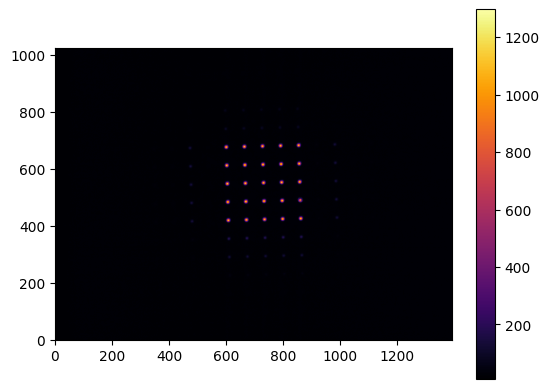

In [46]:
plt.imshow(picture.T, origin="lower", cmap = "inferno")
plt.colorbar()

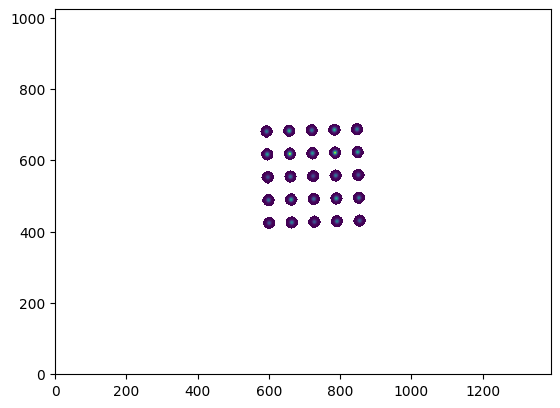

In [38]:
n_rows=5
n_cols=5
m = GridSpotAnalyzer(n_rows, n_cols)
im = m.register_regions_of_interest(picture, relative_threshold=0.27, radius=20)

plt.figure()
plt.imshow(im.T, origin="lower")

intensities = m.compute_intensity_matrix(picture)

In [39]:
(np.max(intensities) - np.min(intensities)) / np.mean(intensities) * 1e2

118.49574254614261

In [40]:
print(np.max(intensities) )
print ( np.min(intensities))
print(np.mean(intensities))

264.94865718799366
87.02555910543131
150.15146895533275


(array([6., 1., 7., 2., 2., 3., 2., 0., 0., 2.]),
 array([0.57958513, 0.69808088, 0.81657662, 0.93507236, 1.0535681 ,
        1.17206385, 1.29055959, 1.40905533, 1.52755107, 1.64604682,
        1.76454256]),
 <BarContainer object of 10 artists>)

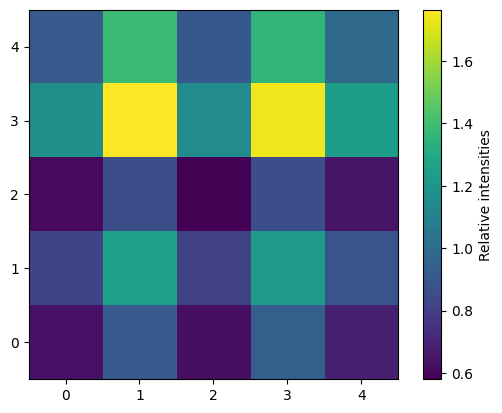

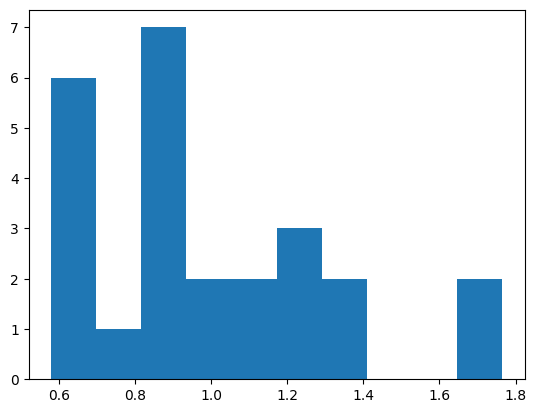

In [41]:
plt.figure()
plt.imshow(intensities.T[::-1, ::] / np.mean(intensities), origin="lower")
cb = plt.colorbar()
cb.set_label("Relative intensities")
plt.figure()
plt.hist((intensities.T / np.mean(intensities)).flatten())

In [42]:
with open("../tweezers.utilities.run_awg/config_x.yaml", "r") as f:
    config_x = StaticTrapConfiguration.from_yaml(f.read())

with open("../tweezers.utilities.run_awg/config_y.yaml", "r") as f:
    config_y = StaticTrapConfiguration.from_yaml(f.read())

In [43]:
w = np.ones((5,7))
w[:,0]*=0.5
intensities, amplitudes_x, amplitudes_y = homogenize(StaticTrapGenerator.from_configuration(config_x), StaticTrapGenerator.from_configuration(config_y),beta=0.3,exposure=30,roi_radius=20, relative_threshold=0.27)


INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel X power for segment segment_0: -5.65 dBm
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel Y power for segment segment_0: -5.65 dBm
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel X power for segment segment_0: -5.65 dBm
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel Y power for segment segment_0: -5.65 dBm
INFO:homogenize.homogenize:std/mean = 37.56%
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel X power for segment segment_0: -5.65 dBm
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel Y power for segment segment_0: -5.65 dBm
INFO:homogenize.homogenize:std/mean = 26.61%
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel X power for segment segment_0: -5.65 dBm
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel Y power for segment segment_0: -5.65 dBm
INFO:homogenize.homogenize:std/mean = 19.58%
INFO:spectum_awg_m4i66xx_x8.runtime.runtime:Channel X power for segment segment_0: -5.65 dBm
INFO:spectum_awg_m4i66xx_x8.

In [44]:
best_shot = np.argmin(np.var(np.var(intensities, axis=-1), axis=-1))
config_x.amplitudes = np.array(amplitudes_x[best_shot]).tolist()
config_y.amplitudes = np.array(amplitudes_y[best_shot]).tolist()

with open("../tweezers.utilities.run_awg/config_x.yaml", "w") as f:
    f.write(config_x.to_yaml())

with open("../tweezers.utilities.run_awg/config_y.yaml", "w") as f:
    f.write(config_y.to_yaml())